# Mapping targets from C to B

This is done to be able to use all data from B with "slightly" different targets than what would be expected.

# Initialize

In [55]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

# Load files

Text(0.5, 1.0, 'Dataset C')

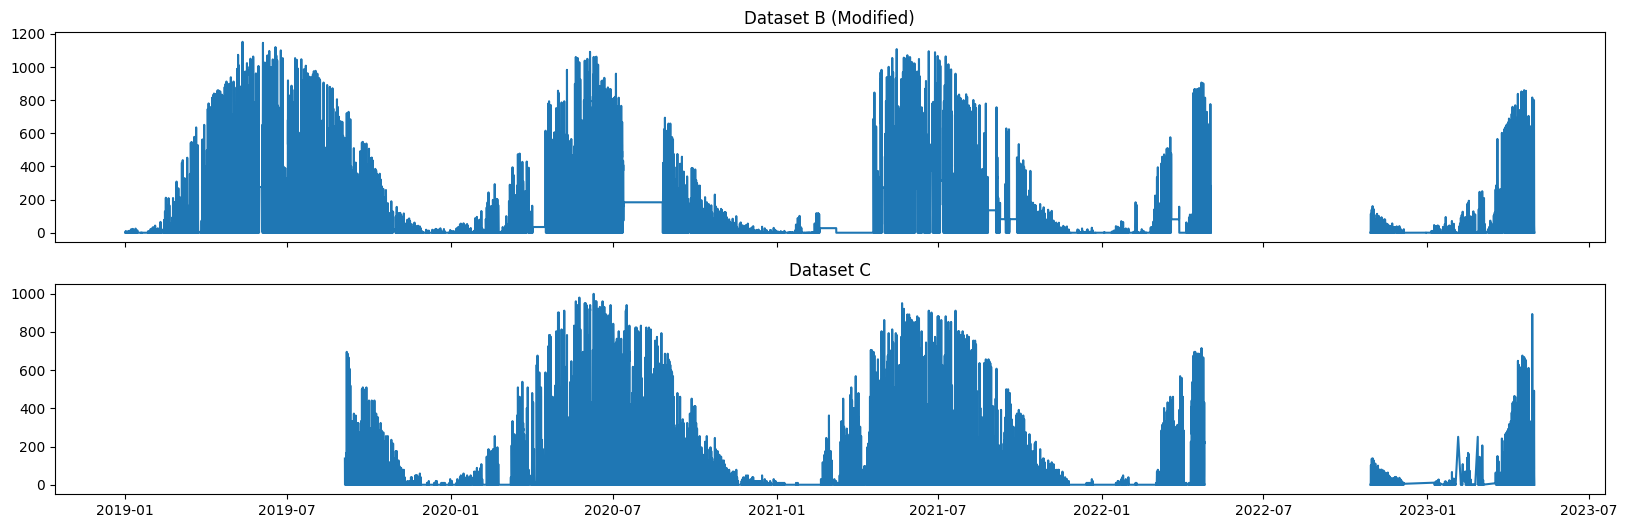

In [69]:
# Load dataset B
file_path_B = 'B/train_targets_B.csv'
data_B = pd.read_csv(file_path_B)

# Load dataset C
file_path_C = 'C/train_targets_C.csv'
data_C = pd.read_csv(file_path_C)

# Convert 'time' column to datetime for easier handling in dataset B
data_B['time'] = pd.to_datetime(data_B['time'])
# Convert 'time' column to datetime for easier handling in dataset C
data_C['time'] = pd.to_datetime(data_C['time'])

fig, axs = plt.subplots(2, 1, figsize=(20, 6), sharex=True)
axs[0].plot(data_B['time'], data_B['pv_measurement'])
axs[0].set_title('Dataset B (Modified)')
axs[1].plot(data_C['time'], data_C['pv_measurement'])
axs[1].set_title('Dataset C')


# Find intervals with broken data in B

In [57]:
# Calculate the difference between consecutive measurements
data_B['diff'] = data_B['pv_measurement'].diff()

# Identify intervals where the difference is zero and the measurement is not 0.0
constant_intervals_B = data_B[(data_B['diff'] == 0) & (data_B['pv_measurement'] != 0) & (data_B['pv_measurement'].notna())]

# Group these intervals and count their lengths
grouped_intervals_B = (constant_intervals_B
                       .assign(group=(constant_intervals_B['time'].diff() != pd.Timedelta(hours=1)).cumsum())
                       .groupby('group')
                       .agg(start_time=('time', 'first'), end_time=('time', 'last'), count=('time', 'count'), constant_value=('pv_measurement', 'first'))
                       .reset_index(drop=True))

# Filter out short intervals (e.g., less than 3 hours) as they might not be considered "broken"
long_constant_intervals_B = grouped_intervals_B[grouped_intervals_B['count'] >= 3]

long_constant_intervals_B.head(200)  # Display the first few rows of long constant intervals in B


,start_time,end_time,count,constant_value
1,2019-01-27 11:00:00,2019-01-28 13:00:00,27,3.4500
2,2019-01-30 11:00:00,2019-01-30 16:00:00,6,6.9000
6,2019-02-26 04:00:00,2019-02-26 07:00:00,4,12.9375
12,2019-05-09 22:00:00,2019-05-10 04:00:00,7,13.8000
13,2019-05-31 08:00:00,2019-06-03 12:00:00,77,276.0000
18,2019-10-28 14:00:00,2019-10-30 22:00:00,57,18.9750
20,2019-12-17 05:00:00,2019-12-17 10:00:00,6,0.8625
27,2020-03-26 14:00:00,2020-03-27 21:00:00,32,118.1625
29,2020-04-02 02:00:00,2020-04-16 06:00:00,341,34.5000
34,2020-07-12 21:00:00,2020-08-25 21:00:00,1057,183.7125


                   time  pv_measurement
0   2018-12-31 23:00:00             0.0
1   2019-01-01 00:00:00             0.0
2   2019-01-01 01:00:00             0.0
3   2019-01-01 02:00:00             0.0
4   2019-01-01 03:00:00             0.0
..                  ...             ...
195 2019-01-09 02:00:00             0.0
196 2019-01-09 03:00:00             0.0
197 2019-01-09 04:00:00             0.0
198 2019-01-09 05:00:00             0.0
199 2019-01-09 06:00:00             0.0

[200 rows x 2 columns]


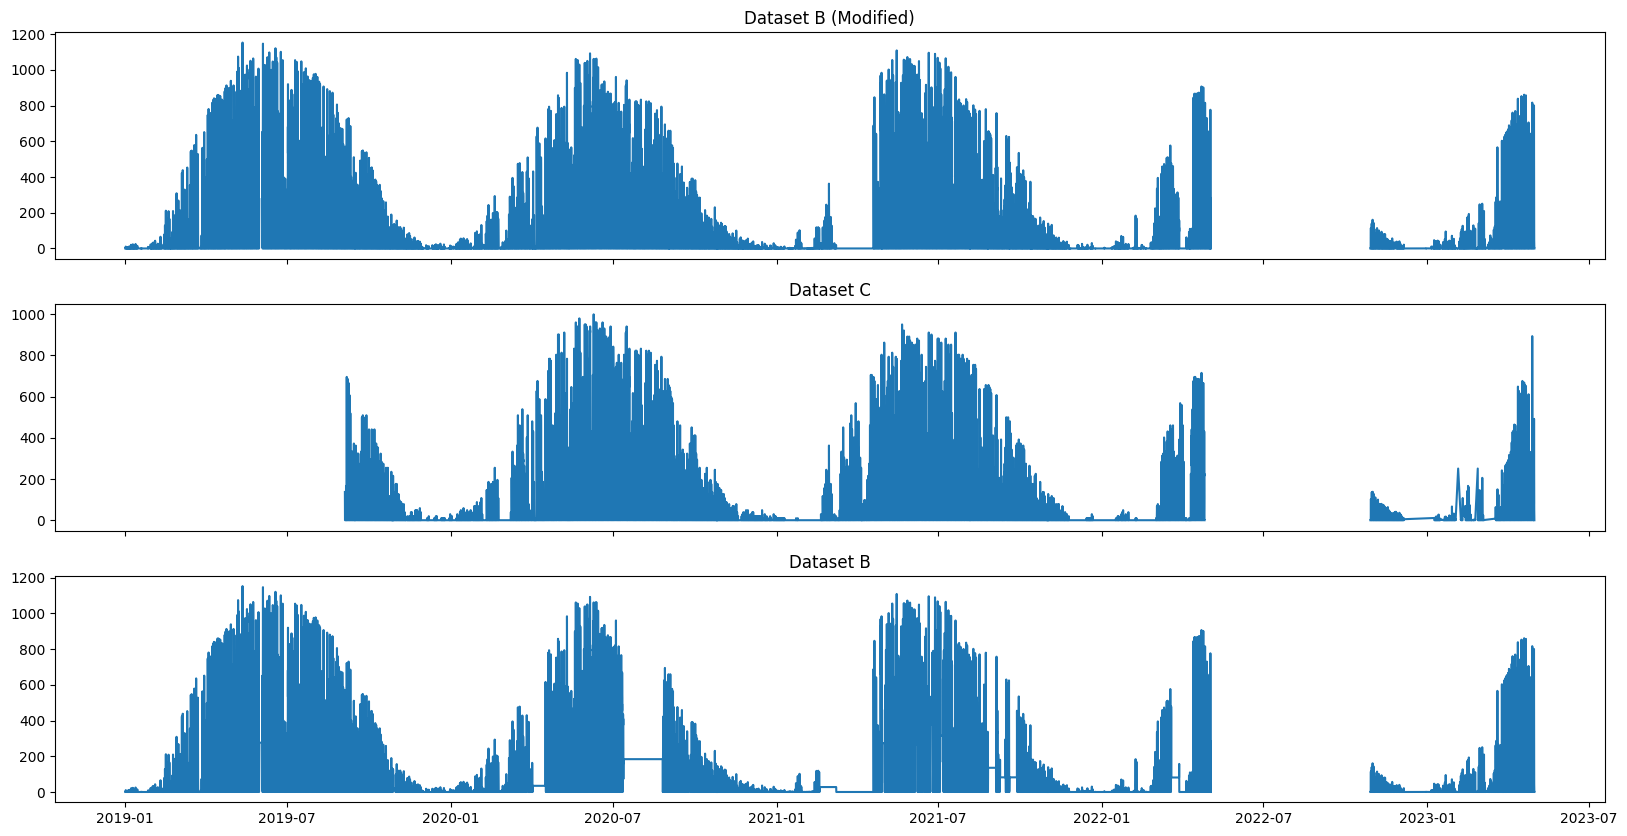

In [72]:
def replace_with_values_from_C(data_B, data_C, constant_intervals):
    data_B_copy = data_B.copy()
    """
    Replace values in dataset B's constant intervals with corresponding values from dataset C.

    :param data_B: DataFrame for dataset B.
    :param data_C: DataFrame for dataset C.
    :param constant_intervals: DataFrame with constant intervals in B to be replaced.
    :return: Modified dataset B with values replaced from C.
    """
    for index, row in constant_intervals.iterrows():
        start_time, end_time = row['start_time'], row['end_time']

        # Iterate through each timestamp within the interval
        for time in pd.date_range(start=start_time, end=end_time, freq='H'):
            # Check if there's a corresponding timestamp in C
            if time in data_C['time'].values:
                # Replace the value in B with the value from C
                value_C = data_C.loc[data_C['time'] == time, 'pv_measurement'].values[0]
                data_B_copy.loc[data_B_copy['time'] == time, 'pv_measurement'] = value_C
    return data_B_copy

# Replace values in dataset B using dataset C for the identified constant intervals
data_B_modified = replace_with_values_from_C(data_B, data_C, long_constant_intervals_B)

# Display the first few rows of modified dataset B
print(data_B_modified.head(200))

fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
axs[0].plot(data_B_modified['time'], data_B_modified['pv_measurement'])
axs[0].set_title('Dataset B (Modified)')
axs[1].plot(data_C['time'], data_C['pv_measurement'])
axs[1].set_title('Dataset C')
axs[2].plot(data_B['time'], data_B['pv_measurement'])
axs[2].set_title('Dataset B')
plt.show()